<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/ConvNet_ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/imageunderstanding'
!ls

/content/drive/MyDrive/imageunderstanding
ExampleSubmissionRandom.csv  PRED_RESULT.csv  Train_labels.csv
Load_data.ipynb		     Test.pkl	      Train.pkl


In [ ]:
%cd '/content/drive/MyDrive/551 A3'
!ls

/content/drive/MyDrive/551 A3
 ExampleSubmissionRandom.csv   Test.pkl		       Train_labels.csv
 LoadData.ipynb		      'Train_labels (1).csv'   Train.pkl


In [3]:
TRAIN_DATA_PATH = "Train.pkl"
TRAIN_LABEL_PATH = "Train_labels.csv"
TEST_DATA_PATH = "Test.pkl"
CSV_OUTPUT_PATH = "PRED_RESULT.csv"

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch
import pandas as pd

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Dataset Class / Data Loaders

In [7]:
IMG_SIZE = (224, 224)

In [8]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5]),
    transforms.Resize(IMG_SIZE)  
    # transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
    # transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, interpolation=<InterpolationMode.NEAREST: 'nearest'>, fill=0, fillcolor=None, resample=None)
])

In [9]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1, usecols=1) #[:,1:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index].squeeze(), int(self.targets[index])
        img = Image.fromarray((img*255).astype('uint8'), mode='L')
        if self.transform is not None:
           img = self.transform(img)
        return img, target

Get loader for all train data

In [10]:
BATCH_SIZE = 128
dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=None)
# dataloader for all data
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Get loaders for train/val data

In [11]:
VAL_SPLIT = 0.15
shuffle = True

# Creating indices for train and val split:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SPLIT * dataset_size))
if shuffle:
  # set random seed so that we get the same split everytime
  np.random.seed(0)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=train_indices)
val_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=val_indices)

# separate loaders for train and val data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Test Dataset / Loader

In [12]:
class MyTestSet(Dataset):
  def __init__(self, img_file, transform=None):
    self.data = pickle.load( open(img_file, 'rb' ), encoding='bytes')
    self.transform = transform

  def __len__(self):
    # return self.data.shape[0]
    return len(self.data)

  def __getitem__(self, index):
    img = self.data[index].squeeze()
    img = Image.fromarray((img*255).astype('uint8'), mode='L')
    if self.transform is not None:
      img = self.transform(img)
    return img

In [13]:
test_dataset = MyTestSet(TEST_DATA_PATH,transform=img_transform)
# dataloader for test data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## ResNet18

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision.models as models

Let's train these. But first, create the network, the optimizer and some lists for logging the training process

### alexnet

In [ ]:
# model = models.alexnet(pretrained=False)
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
# model.classifier[6] = nn.Linear(4096, 10)
# model = model.to(DEVICE)

### resnet18

In [ ]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(DEVICE)

### resnet34

In [15]:
model = models.resnet34(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(DEVICE)

### optimizer & initialization

In [18]:
# optimizer = optim.SGD(tutor_model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.SGD(tutor_model.parameters(), lr=1, momentum=0.5)
# optimizer = optim.Adam(model.parameters())
optimizer = optim.RMSprop(model.parameters())

train_losses = []
train_counter = []
val_losses = []
val_counter = [i*len(train_loader.dataset) for i in range(3)]

### Train and test function, used many times

In [22]:
def train(epoch, model, loader):
  model.train()
  for batch_idx, (data, target) in enumerate(loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    # print(data.shape)
    target = target.to(DEVICE)
    output = model(data)
    # print(output.shape)
    # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D
    loss = F.cross_entropy(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 200 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(loader.dataset),
        100. * batch_idx / len(loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(loader.dataset)))
      torch.save(model.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def val(model, loader):
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = model(data)
      val_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  val_loss /= len(loader.dataset)
  val_losses.append(val_loss)
  print('Val set: Epoch: {}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    epoch, val_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)))

Train the network

In [20]:
for epoch in range(1, 30):
  train(epoch, model, train_loader)
  val(model, val_loader)

Train Epoch: 1 [0/51000 (0%)]	Loss: 2.510531
Train Epoch: 1 [25600/51000 (50%)]	Loss: 1.556017


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: Epoch: 1, Avg. loss: 1.2686, Accuracy: 5900/9000 (66%)
Train Epoch: 2 [0/51000 (0%)]	Loss: 0.572796
Train Epoch: 2 [25600/51000 (50%)]	Loss: 0.233853
Val set: Epoch: 2, Avg. loss: 1.4659, Accuracy: 6148/9000 (68%)
Train Epoch: 3 [0/51000 (0%)]	Loss: 0.888014
Train Epoch: 3 [25600/51000 (50%)]	Loss: 0.161264
Val set: Epoch: 3, Avg. loss: 0.3924, Accuracy: 8083/9000 (90%)
Train Epoch: 4 [0/51000 (0%)]	Loss: 0.164351
Train Epoch: 4 [25600/51000 (50%)]	Loss: 0.145888
Val set: Epoch: 4, Avg. loss: 0.3041, Accuracy: 8238/9000 (92%)
Train Epoch: 5 [0/51000 (0%)]	Loss: 0.199020
Train Epoch: 5 [25600/51000 (50%)]	Loss: 0.121279
Val set: Epoch: 5, Avg. loss: 2.3097, Accuracy: 5868/9000 (65%)
Train Epoch: 6 [0/51000 (0%)]	Loss: 0.274825
Train Epoch: 6 [25600/51000 (50%)]	Loss: 0.128755
Val set: Epoch: 6, Avg. loss: 0.1473, Accuracy: 8652/9000 (96%)
Train Epoch: 7 [0/51000 (0%)]	Loss: 0.061915
Train Epoch: 7 [25600/51000 (50%)]	Loss: 0.037681
Val set: Epoch: 7, Avg. loss: 0.1382, Accuracy

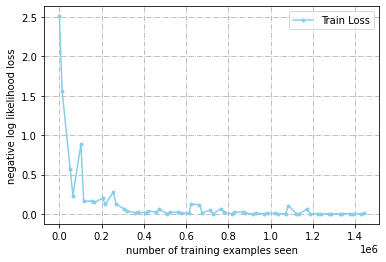

In [21]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='skyblue',marker='.')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.grid(linestyle='-.')

## Train on ALL data

In [23]:
full_model = models.resnet34(pretrained=False)
full_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
full_model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
full_model = full_model.to(DEVICE)
optimizer = optim.RMSprop(full_model.parameters())

In [24]:
for epoch in range(1, 28):
  train(epoch, full_model, data_loader)
  val(full_model, val_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.399856
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.602639
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.589910


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: Epoch: 1, Avg. loss: 3.2175, Accuracy: 3782/9000 (42.02%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.417773
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.256783
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.178114
Val set: Epoch: 2, Avg. loss: 1.0682, Accuracy: 6594/9000 (73.27%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.165450
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.091979
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.154500
Val set: Epoch: 3, Avg. loss: 0.1638, Accuracy: 8526/9000 (94.73%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.188917
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.073150
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.118020
Val set: Epoch: 4, Avg. loss: 0.1087, Accuracy: 8682/9000 (96.47%)
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.132723
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.145378
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.043925
Val set: Epoch: 5, Avg. loss: 0.0845, Accuracy: 8769/9000 (97.43%)
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.062098
Train Epoch: 6 [25600/60000 (43%)]	Loss:

## Make predictions on test data

In [25]:
def predict(model):
  pred_test = []
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      data = data.to(DEVICE)
      output = model(data)
      pred = output.data.max(1, keepdim=True)[1]
      for x in pred:
        pred_test.append(x.item())
  return pred_test

In [26]:
pred_test = predict(full_model)
print(len(pred_test))
df_pred_test = pd.DataFrame({'id': range(10000), 'class': pred_test})
df_pred_test.to_csv(CSV_OUTPUT_PATH, index=False)

10000


## Manually check prediction results

torch.Size([128, 1, 224, 224])
torch.Size([128, 224, 224])


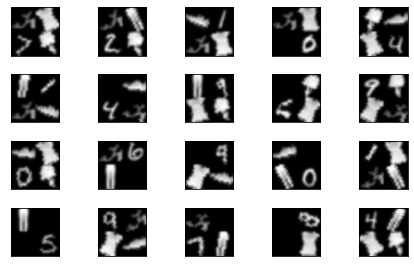

In [ ]:
# Read many TEST data and display them, compare with our prediction in CSV
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
imgs = (next(iter(test_loader)))
print(imgs.shape)
# imgs: [256, 1, 28, 28]
imgs = np.squeeze(imgs)
# imgs: [256, 28, 28]
print(imgs.shape)

for i in range(20):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(imgs[i], cmap='gray', interpolation='bicubic')
  plt.xticks([])
  plt.yticks([])

## Deeper（doesn't work）

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    
    self.model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3), nn.ReLU(), # 26*26
      nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(), # 24*24
      # nn.MaxPool2d(2,2), # 13*13

      nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),  # 22*22
      nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),  # 20*20
      # nn.MaxPool2d(2,2),  # 6*6

      nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),  # 18*18
      nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),  # 16*16
      # nn.MaxPool2d(2,2),  # 2*2

      nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(), # 14*14
      nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),  # 12*12
      # nn.MaxPool2d(2,2),

      nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),  # 10*10
      nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),  # 8*8
      nn.MaxPool2d(2,2),  # 4*4

    )
    
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(0.25),
      # nn.Linear(4096, 256),
      nn.Linear(4096, 256),
      nn.ReLU(),

      nn.Dropout(0.5),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )
    
  def forward(self, x):
    f = self.model(x)
    y_pred = self.classifier(f)
    return y_pred

network = MyModel()
# summary(model, (3,256,256))

In [ ]:
optimizer = optim.Adam(network.parameters())

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)

    loss = F.nll_loss(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader:
      output = network(data)
      # this line is added to convert labels to LongTensor
      # target = target.type(torch.LongTensor)
      # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D

      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader.dataset),
    100. * correct / len(val_loader.dataset)))

In [ ]:
for epoch in range(1, 4):
  train(epoch)
  test()

In [ ]:
print(torch.cuda.is_available())

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Linear(3136, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        # print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # input 1*28*28
        self.conv1 = nn.Conv2d(1, 96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.max_pool2d(torch.relu(self.conv1(x)), kernel_size=3, stride=2) # 96 filters + maxpooling => 96*27*27
        x = F.max_pool2d(torch.relu(self.conv2(x)), kernel_size=3, stride=2) # 256 filters + maxpooling => 256*13*13
        x = torch.relu(self.conv3(x)) # 384 filters => 384*13*13
        x = torch.relu(self.conv4(x)) # 384 filters => 384*13*13
        x = F.max_pool2d(torch.relu(self.conv5(x)), kernel_size=3, stride=2) # 256 filters => 256*6*6
        x = self.dropout(x) 
        x = x.view(-1, 256*6*6) 
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x)